In [57]:
#load all the files for a user
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 

pd.options.mode.chained_assignment = None

#Load file names for user. Change here for different user replace 000 or even path as required
filenames = glob.glob("C:/Users/shr7abt/Documents/Location/Data/Geolife Trajectories 1.3/Data/017/Trajectory/200*.plt")

#Read the files
list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

#put the data from list into one dataframe
combined_df = pd.concat(list_of_dfs, ignore_index=True)

#rename columns
combined_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
combined_df['ClusterId'] = -1
combined_df['ClusterMeanLat'] = -1
combined_df['ClusterMeanLon'] = -1
combined_df['StayPoint'] = -1
combined_df['SignificantPlace'] = -1

#add timestamp index
combined_df["Timestamp"] = combined_df["Date"].map(str) + " " + combined_df["Time"]
combined_df.Timestamp = pd.to_datetime(combined_df.Timestamp)
combined_df.index = pd.to_datetime(combined_df.Timestamp)

#combined_df.size
combined_df.head()

,Latitude,Longitude,0,Altitude,NumDays,Date,Time,ClusterId,ClusterMeanLat,ClusterMeanLon,StayPoint,SignificantPlace,Timestamp
Timestamp,,,,,,,,,,,,,
2008-10-30 09:27:48,39.986477,116.320150,0,147.6,39751.394306,2008-10-30,09:27:48,-1,-1,-1,-1,-1,2008-10-30 09:27:48
2008-10-30 09:27:49,39.986480,116.320185,0,147.6,39751.394317,2008-10-30,09:27:49,-1,-1,-1,-1,-1,2008-10-30 09:27:49
2008-10-30 09:27:52,39.986457,116.320282,0,147.6,39751.394352,2008-10-30,09:27:52,-1,-1,-1,-1,-1,2008-10-30 09:27:52
2008-10-30 09:27:55,39.986528,116.320337,0,147.6,39751.394387,2008-10-30,09:27:55,-1,-1,-1,-1,-1,2008-10-30 09:27:55
2008-10-30 09:27:58,39.986525,116.320427,0,147.6,39751.394421,2008-10-30,09:27:58,-1,-1,-1,-1,-1,2008-10-30 09:27:58


In [58]:
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

In [59]:
#This function is to cluster the points together if thier distance is less than 50 meters.
#If the cluster has a total duration of 10 minutes or greater, then add it to a stay point

def cluster(newlat, newlon, row, count):
    
    currcluster = sampled_df['ClusterId'][row-1]
    sampled_df['ClusterId'][row] = -1
    sampled_df['ClusterMeanLat'][row] = -1
    sampled_df['ClusterMeanLon'][row] = -1
    sampled_df['StayPoint'][row] = -1
    sampled_df['SignificantPlace'][row] = -1
    clulat = sampled_df['ClusterMeanLat'][row-1]
    clulon = sampled_df['ClusterMeanLon'][row-1]
    
    #import pdb; pdb.set_trace()
    if meters(clulat, clulon, newlat, newlon)<= 50:
        sampled_df['ClusterId'][row] = currcluster
        sampled_df['ClusterMeanLat'] = sampled_df.groupby('ClusterId')['Latitude'].transform(np.mean)
        sampled_df['ClusterMeanLon'] = sampled_df.groupby('ClusterId')['Longitude'].transform(np.mean)
        count = count + 1
    else:
        
        if count >= 2:
            #import pdb; pdb.set_trace()
            MinClusTime = sampled_df['Timestamp'][row-count]
            MaxClusTime = sampled_df['Timestamp'][row-1]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            #import pdb; pdb.set_trace()
            if (l >= 10):
                sampled_df.loc[ (sampled_df['ClusterId']==currcluster), 'StayPoint'] = 1
        count = 1
        sampled_df['ClusterMeanLat'][row] = sampled_df['Latitude'][row]
        sampled_df['ClusterMeanLon'][row] = sampled_df['Longitude'][row]
        sampled_df['ClusterId'][row] = currcluster + 1
    return count

In [60]:
#Resample the data with every two minutes. Remove this if you like to process the entire file.
#Note, it could take some time to run the further sections of the file size is very large.
sampled_df = combined_df.resample('2T').mean()
sampled_df["Timestamp"] = sampled_df.index
sampled_df = sampled_df.dropna()

#Select the data you want to proceed with
sampled_df = sampled_df[sampled_df["Timestamp"] <= "2008-11-30 00:00:00"]

#len(sampled_df)
#sampled_df.tail()

In [61]:
#Read the file in an online manner as the points come and assign the points to clusters

row =1
count = 1
sampled_df['ClusterId'][row-1] = 0
sampled_df['ClusterMeanLat'][row-1] = sampled_df['Latitude'][0]
sampled_df['ClusterMeanLon'][row-1] = sampled_df['Longitude'][0]
sampled_df['StayPoint'][row-1] = -1
sampled_df['SignificantPlace'][row-1] = -1
while row < len(sampled_df):
    #values are already sorted here. Add this when the process is online
    #sampled_df = sampled_df.sort_values(by=['Latitude', 'Longitude'])
    #import pdb; pdb.set_trace()
    count = cluster(sampled_df['Latitude'][row], sampled_df['Longitude'][row], row, count)
    row= row + 1

In [62]:
#Save the file to a location for further analysis. Change the file name accordingly
sampled_df.to_csv('C:/Users/shr7abt/Documents/Location/Data/StayPointsUser17(octnov2008)', sep='\t', encoding='utf-8')

In [63]:
#copy the significant places into another dataframe for visualization
staypts_df = sampled_df.loc[sampled_df['StayPoint'] == 1]
staypts_df['ClusterId'].nunique()

63

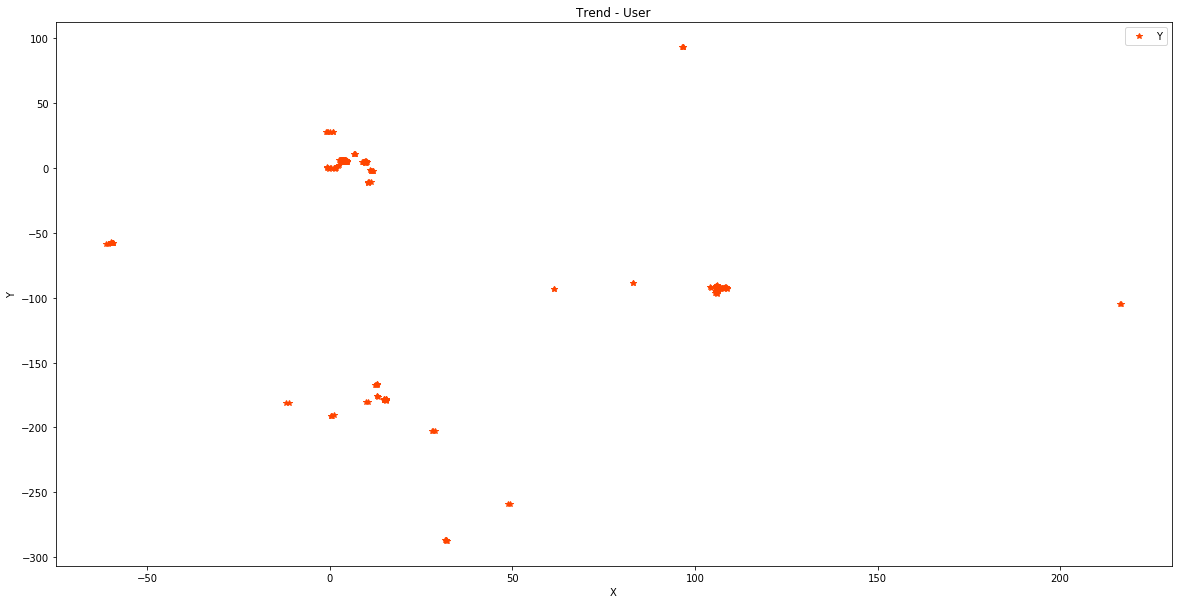

In [64]:
#Plot the significant places
#assign the first lat and log as the base for the plot i.e. origin
origin_lat = math.radians(combined_df["Latitude"][0])
origin_lon = math.radians(combined_df["Longitude"][0])
staypts_df = staypts_df.reset_index(drop=True)

#assign the first lat and log as the base for the plot i.e. origin
origin_lat = math.radians(staypts_df["Latitude"][0])
origin_lon = math.radians(staypts_df["Longitude"][0])

#convert each lat and lon into x and y for the plot w.r.t origin
EARTH_RAD = 6378100
staypts_df['X'] = 0.0
staypts_df['Y'] = 0.0
for i in range(0, len(staypts_df)):
    x = 0
    y = 0
    current_lat = math.radians(staypts_df["Latitude"][i])
    current_lon = math.radians(staypts_df["Longitude"][i])
    x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
    y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
    staypts_df.at[i, 'X'] = x
    staypts_df.at[i, 'Y'] = y

#plot the x and y's
staypts_df.plot(x='X', y= 'Y' , style='*', figsize=(20,10), color='orangered')
plt.title('Trend - User')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()